In [116]:
# import libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import random

In [103]:
def preprocess_img(img_path):
    note = cv2.imread(img_path, 0)
    _, note = cv2.threshold(note, 127, 255, cv2.THRESH_BINARY)
    return note

In [ ]:
def add_padding_variants(img, num_variants, max_pad):
    variants = []
    h, w = img.shape

    for _ in range(num_variants):
        top = np.random.randint(50, max_pad)
        bottom = np.random.randint(50, max_pad)
        left = np.random.randint(50, max_pad)
        right = np.random.randint(50, max_pad)

        padded = cv2.copyMakeBorder(
            img,
            top,
            bottom,
            left,
            right,
            borderType=cv2.BORDER_REPLICATE
        )
        resized = cv2.resize(padded, (w, h))
        variants.append(resized)
    return variants


In [105]:
def add_translation_variants(img, num_variants):
    variants = []
    h, w = img.shape

    for _ in range(num_variants):
        # Random translation (shift)
        tx = np.random.randint(-20, 20)
        ty = np.random.randint(-20, 20)
        M_shift = np.float32([[1, 0, tx], [0, 1, ty]])
        shifted = cv2.warpAffine(img, M_shift, (w, h), borderValue=255)
        variants.append(shifted)
    
    return variants

In [106]:
def add_rotated_variants(img, num_variants):
    variants = []
    h, w = img.shape
    center = (w // 2, h // 2)  # Note: width comes first for center

    for _ in range(num_variants):
        # Random rotation
        angle = np.random.uniform(-5, 5)
        M_rot = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(img, M_rot, (w, h), borderValue=255)
        variants.append(rotated)
    
    return variants

In [107]:
def add_blurred_variants(img, num_variants):
    variants = []
    h, w = img.shape

    for _ in range(num_variants):
        blurred = cv2.GaussianBlur(img, (21, 21), 0)
        variants.append(blurred)
    
    return(variants)

In [226]:
def add_vstretched_variants(img, num_variants):
    variants = []
    h, w = img.shape

    for _ in range(num_variants):
        # Pick a vertical stretch/compression factor
        stretch_factor = random.uniform(0.5, 1.5)
        new_h = int(h * stretch_factor)

        # Affine transform matrix to scale vertically
        M = np.float32([[1, 0, 0],
                        [0, stretch_factor, 0]])
        stretched = cv2.warpAffine(img, M, (w, new_h), borderValue=255)

        # Create a white canvas of original size (h, w)
        canvas = np.ones((h, w), dtype=np.uint8) * 255

        # Center vertically
        if new_h <= h:
            y_offset = (h - new_h) // 2
            canvas[y_offset:y_offset+new_h, :] = stretched
        else:
            # If stretched is taller, crop to center
            start_y = (new_h - h) // 2
            canvas = stretched[start_y:start_y+h, :]

        variants.append(canvas)

    return variants


In [182]:
def add_hstretched_variants(img, num_variants):
    variants = []
    h, w = img.shape

    for _ in range(num_variants):
        # Choose a random horizontal stretch/compression factor
        stretch_factor = random.uniform(0.5, 1.5)
        new_w = int(w * stretch_factor)

        # Create affine matrix and warp to new width
        M = np.float32([[stretch_factor, 0, 0],
                        [0, 1, 0]])
        stretched = cv2.warpAffine(img, M, (new_w, h), borderValue=255)

        # Create a blank white canvas of original size
        canvas = np.ones((h, w), dtype=np.uint8) * 255

        # Center the stretched content
        if new_w <= w:
            x_offset = (w - new_w) // 2
            canvas[:, x_offset:x_offset+new_w] = stretched
        else:
            # If stretched content is wider, crop it to fit center
            start_x = (new_w - w) // 2
            canvas = stretched[:, start_x:start_x+w]

        variants.append(canvas)

    return variants


In [259]:
def add_zoomed_variants(img, num_variants):
    variants = []
    h, w = img.shape
    for _ in range(num_variants):
        zoom_factor = random.uniform(*(1.1, 2.0))

        # Calculate size of the zoomed crop
        new_h = int(h / zoom_factor)
        new_w = int(w / zoom_factor)

        # Ensure we don't exceed bounds
        start_y = (h - new_h) // 2
        start_x = (w - new_w) // 2

        # Crop center of the image
        cropped = img[start_y:start_y+new_h, start_x:start_x+new_w]

        # Resize back to original size (simulates zoom-in)
        zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)

        variants.append(zoomed)

    return(variants)

In [261]:
def add_combined_variants(img, num_variants, max_pad):
    variants = []

    for _ in range(num_variants):
        pad = np.random.randint(0, 2)
        translate = np.random.randint(0,2)
        blur = np.random.randint(0,2)
        vstretch = np.random.randint(0,2)
        hstretch = np.random.randint(0,2)
        zoom = np.random.randint(0,2)

        img_arr = []
        img_arr.append(img)
        if(pad == 1):
            img_arr = add_padding_variants(img_arr[0], 1, max_pad)
        if translate == 1:
            img_arr = add_translation_variants(img_arr[0], 1)
        if blur == 1:
            img_arr = add_blurred_variants(img_arr[0], 1)
        if vstretch == 1:
            img_arr = add_vstretched_variants(img_arr[0], 1)
        if hstretch == 1:
            img_arr = add_hstretched_variants(img_arr[0], 1)
        if zoom == 1:
            img_arr = add_zoomed_variants(img_arr[0], 1)
        
        variants.append(img_arr[0])
    
    return variants



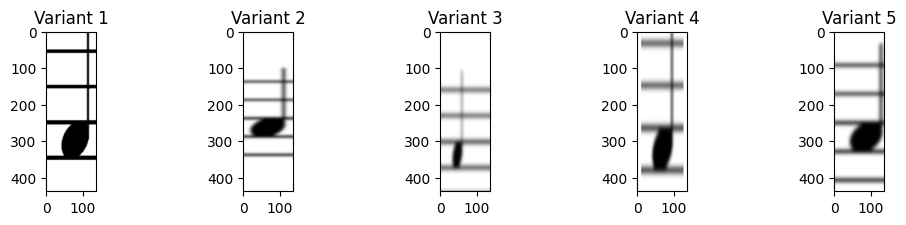

In [268]:
# img = cv2.imread("images/original_notes_images/C4.png", 0)
img = preprocess_img("images/original_notes_images/A4.png")

vars = add_combined_variants(img, 5, 200)
n = len(vars)
cols = 5
rows = (n+cols-1)

plt.figure(figsize=(cols*2, rows*2))
for i, img in enumerate(vars):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('on')
    plt.title(f"Variant {i+1}")
plt.tight_layout()
plt.show()

In [269]:
def create_dataset(num_variants, max_pad, image_list, new_directory):
    for image_path in image_list:
        # get note name
        note_name = image_path.split('/')[-1].replace('.png', '')
        
        # preprocess
        note = preprocess_img(image_path)

        # create variants
        note_pad = add_padding_variants(note, num_variants, max_pad)
        note_shift = add_translation_variants(note, num_variants)
        note_rot = add_rotated_variants(note, num_variants)
        note_blur = add_blurred_variants(note, num_variants)
        note_vstretch = add_vstretched_variants(note, num_variants)
        note_hstretch = add_hstretched_variants(note, num_variants)
        note_combined = add_combined_variants(note, num_variants*2, max_pad)
        note_zoomed = add_zoomed_variants(note, num_variants)
        note_all  = np.concatenate([note_pad, note_shift, note_rot, note_blur, note_vstretch, note_hstretch, note_zoomed, note_combined], axis=0)

        # save variants
        for i, img in enumerate(note_all):
            cv2.imwrite(f'{new_directory}{note_name}_{i}.png', img)

In [270]:
base_dir = 'images/original_notes_images/'
training_dir = "images/training_notes/"
num_variants = 25
max_pad = 200
file_paths = []

# read in files
for filename in os.listdir(base_dir):
    if filename.endswith('.png'):
        file_paths.append(os.path.join(base_dir, filename))

# create training dataset
create_dataset(num_variants, max_pad, file_paths, training_dir)




In [ ]:
# base_dir = 'images/original_notes_images/'
# test_ds_dir = "images/testing/"
# num_variants = 1
# max_pad = 400
# file_paths = []

# # read in files
# for filename in os.listdir(base_dir):
#     if filename.endswith('.png'):
#         file_paths.append(os.path.join(base_dir, filename))

# # create training dataset
# create_dataset(num_variants, max_pad, file_paths, test_ds_dir)




438 136


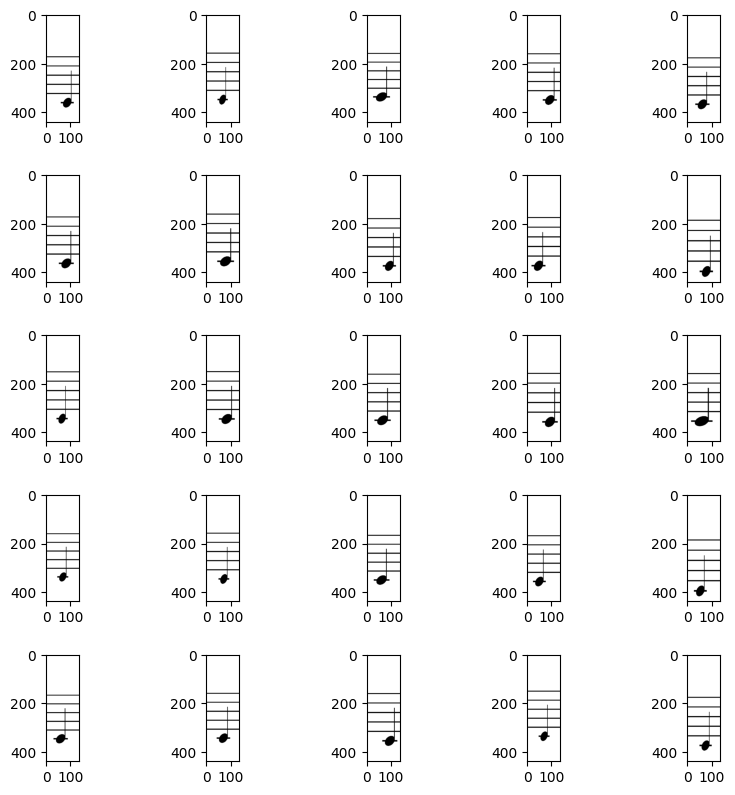

In [192]:
note = preprocess_img("images/original_notes_images/C4.png")
note_pad = add_padding_variants(note, num_variants, 100)
h, w = note.shape
print(h, w)
cols = 5
rows = (n+cols-1)
i = 0

plt.figure(figsize=(cols*2, rows*2))
plt.subplots_adjust(hspace=0.5)  # Increase vertical spacing

for i, image in enumerate(note_pad):
    plt.subplot(rows, cols, i+1)
    plt.imshow(image.reshape(h, w), cmap='gray')
    plt.axis('on')

In [ ]:
# base_dir = 'images/test_dir/sample/'
# training_dir = 'images/test_dir/output/'
# num_variants = 25
# max_pad = 50
# file_paths = []

# # read in files
# for filename in os.listdir(base_dir):
#     if filename.endswith('.png'):
#         file_paths.append(os.path.join(base_dir, filename))

# create_dataset(num_variants, max_pad, file_paths, training_dir)